# References

## Main reference

* https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3

## Other eferences

* https://lamfo-unb.github.io/2019/09/02/cluster_texto/
* https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python
* https://geodacenter.github.io/workbook/7c_clusters_3/lab7c.html
* https://paginas.fe.up.pt/~ec/files_1112/week_05_Clustering.pdf
* https://paginas.fe.up.pt/~ec/
* https://medium.com/analytics-vidhya/k-means-clustering-in-python-80b7ac147eee
* https://medium.com/analytics-vidhya/k-means-clustering-in-python-80b7ac147eee
* https://realpython.com/k-means-clustering-python/

In [56]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import nltk
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osvaldo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [46]:
data = pd.read_csv('winemag.csv', encoding = 'utf-8', sep = ',')

data = data.drop('Unnamed: 0', axis = 1)

data.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [65]:
df = data[data['variety'] == 'Chardonnay'].copy()

df = df.reset_index()

df.head()

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,14,US,"Building on 150 years and six generations of winemaking tradition, the winery trends toward a leaner style, with the classic California buttercream aroma cut by tart green apple. In this good everyday sipping wine, flavors that range from pear to barely ripe pineapple prove approachable but not distinctive.",NaN,87,12.0,California,Central Coast,Central Coast,Matt Kettmann,@mattkettmann,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou
1,55,US,"This shows jelly-like flavors of orange and pear, with some earthy tones. The mouthfeel is soft and there's a bounty of oak in the form of buttered toast and caramel notes.",Estate Bottled,85,30.0,California,Napa Valley,Napa,NaN,NaN,RustRidge 2010 Estate Bottled Chardonnay (Napa Valley),Chardonnay,RustRidge
2,56,US,"This is weighty, creamy and medium to full in body. It has plenty of lime and pear flavors, plus slight brown sugar and vanilla notes.",NaN,85,14.0,California,North Coast,North Coast,Virginie Boone,@vboone,Souverain 2010 Chardonnay (North Coast),Chardonnay,Souverain
3,65,France,"From the warm 2015 vintage, this is a soft and fruity wine. It's open with broad white fruit flavors, the acidity lighter than usual for Chablis, giving it a particularly ripe character. Drink now.",NaN,86,24.0,Burgundy,Chablis,NaN,Roger Voss,@vossroger,Simonnet-Febvre 2015 Chablis,Chardonnay,Simonnet-Febvre
4,66,France,"This soft, rounded wine is ripe with generous pear and melon flavors. It's easy and ready to drink young for its smooth, attractively ripe character.",NaN,86,15.0,Burgundy,Mâcon-Milly Lamartine,NaN,Roger Voss,@vossroger,Vignerons des Terres Secrètes 2015 Mâcon-Milly Lamartine,Chardonnay,Vignerons des Terres Secrètes


Word Count Median: 38.0
count    11753.000000
mean     38.352931   
std      10.891093   
min      3.000000    
25%      31.000000   
50%      38.000000   
75%      45.000000   
max      104.000000  
Name: word_count, dtype: float64


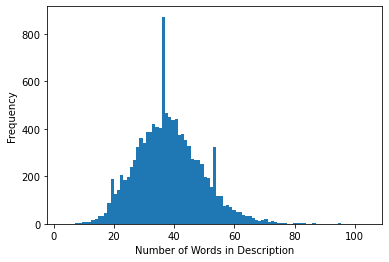

In [66]:
#add a column for the word count
df['word_count'] = df['description'].apply(lambda x: len(str(x).split(" ")))

print("Word Count Median: " + str(df['word_count'].median()))
print(df['word_count'].describe())

x = df['word_count']

n_bins = 95
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

82.0
count    65.000000
mean     82.630769
std      1.790332 
min      80.000000
25%      82.000000
50%      82.000000
75%      84.000000
max      89.000000
Name: points, dtype: float64


Text(0.5, 1.0, 'Points Counts')

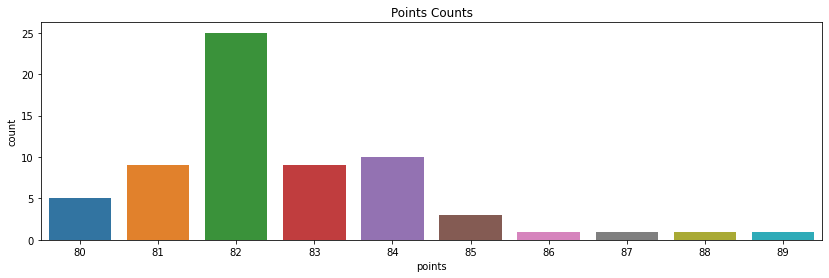

In [67]:
#word counts less than 15
wc15 = df.loc[df['word_count'] < 15]

print(wc15.points.median())
print(wc15.points.describe())

#plot the counts
plt.figure(figsize=(14,4))
sns.countplot(x ='points', data = wc15).set_title("Points Counts")

93.0
count    60.000000
mean     92.600000
std      2.532501 
min      85.000000
25%      91.000000
50%      93.000000
75%      94.000000
max      98.000000
Name: points, dtype: float64


Text(0.5, 1.0, 'Points Counts')

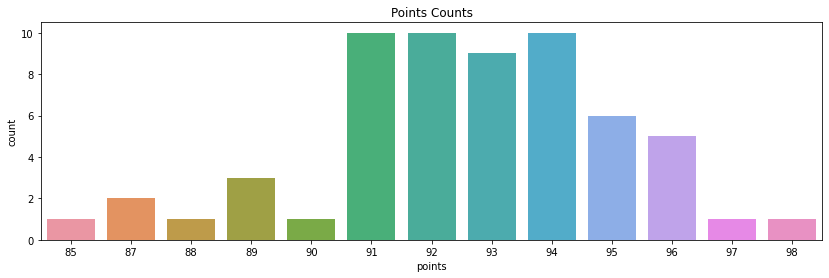

In [68]:
#word counts greater than 70
wc70 = df.loc[df['word_count'] > 70]

print(wc70.points.median())
print(wc70.points.describe())

#plot the counts
plt.figure(figsize=(14,4))
sns.countplot(x ='points', data = wc70).set_title("Points Counts")

Number of Unique Points: 21
Points Median: 88.0
count    11753.000000
mean     88.340083   
std      3.231557    
min      80.000000   
25%      86.000000   
50%      88.000000   
75%      91.000000   
max      100.000000  
Name: points, dtype: float64


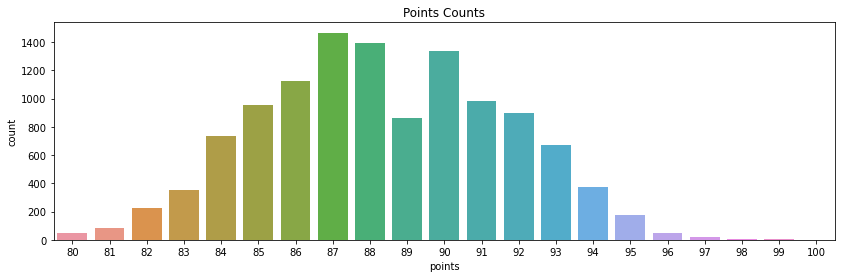

In [86]:
print("Number of Unique Points: " + str(len(df['points'].unique())))
print("Points Median: " + str(df['points'].median()))
print(df['points'].describe())

plt.figure(figsize=(14,4))

sns.countplot(x='points', data=df).set_title("Points Counts")
plt.show()

#add column to flag records with rating greater than 88
df['above_avg'] = [1 if points > 88 else 0 for points in df['points']]

In [70]:
nltk.download('wordnet')

#create a list of stop words
stop_words = set(stopwords.words("english"))

#show how many words are in the list of stop words
print(len(stop_words))
#179

#construct a new list to store the cleaned text
clean_desc = []
for w in range(0,len(df.description)):
    desc = df['description'][w].lower()
    
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove special characters and digits
    desc = re.sub("(\\d|\\W)+"," ",desc)
    
    split_text = desc.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
    split_text = " ".join(split_text)
    clean_desc.append(split_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Osvaldo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


179


In [71]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,1))

#transform
vec_text = tfv.fit_transform(clean_desc)

#returns a list of words.
words = tfv.get_feature_names()

In [75]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 21, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)

#fit the data 
kmeans.fit(vec_text)

#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : cru, premier, grand, wine, drink, crus, vineyard, fruit, ripe, aging
1 : buttered, toast, pineapple, flavor, vanilla, chardonnay, jam, orange, acidity, oak
2 : green, apple, flavor, wine, crisp, fruit, chardonnay, light, fresh, acidity
3 : french, barrel, fermented, oak, new, aged, wine, stainless, fruit, apple
4 : wood, wine, fruit, aging, ripe, drink, rich, yellow, acidity, flavor
5 : year, age, wine, fruit, acidity, structure, ripe, rich, least, wood
6 : aroma, finish, melon, flavor, feel, apple, palate, fruit, oak, resiny
7 : medium, bodied, finish, apple, flavor, wine, aroma, palate, note, pear
8 : blanc, de, wine, mineral, drink, crisp, sauvignon, grand, cru, tight
9 : sweet, like, pineapple, simple, taste, flavor, vanilla, orange, chardonnay, apricot
10 : fruit, wine, chardonnay, flavor, citrus, finish, peach, oak, tropical, apple
11 : crisp, wine, bright, fresh, acidity, fruity, lively, aftertaste, attractive, drink
12 : ready, drink, wine, soft, fruity, attractive, acidity

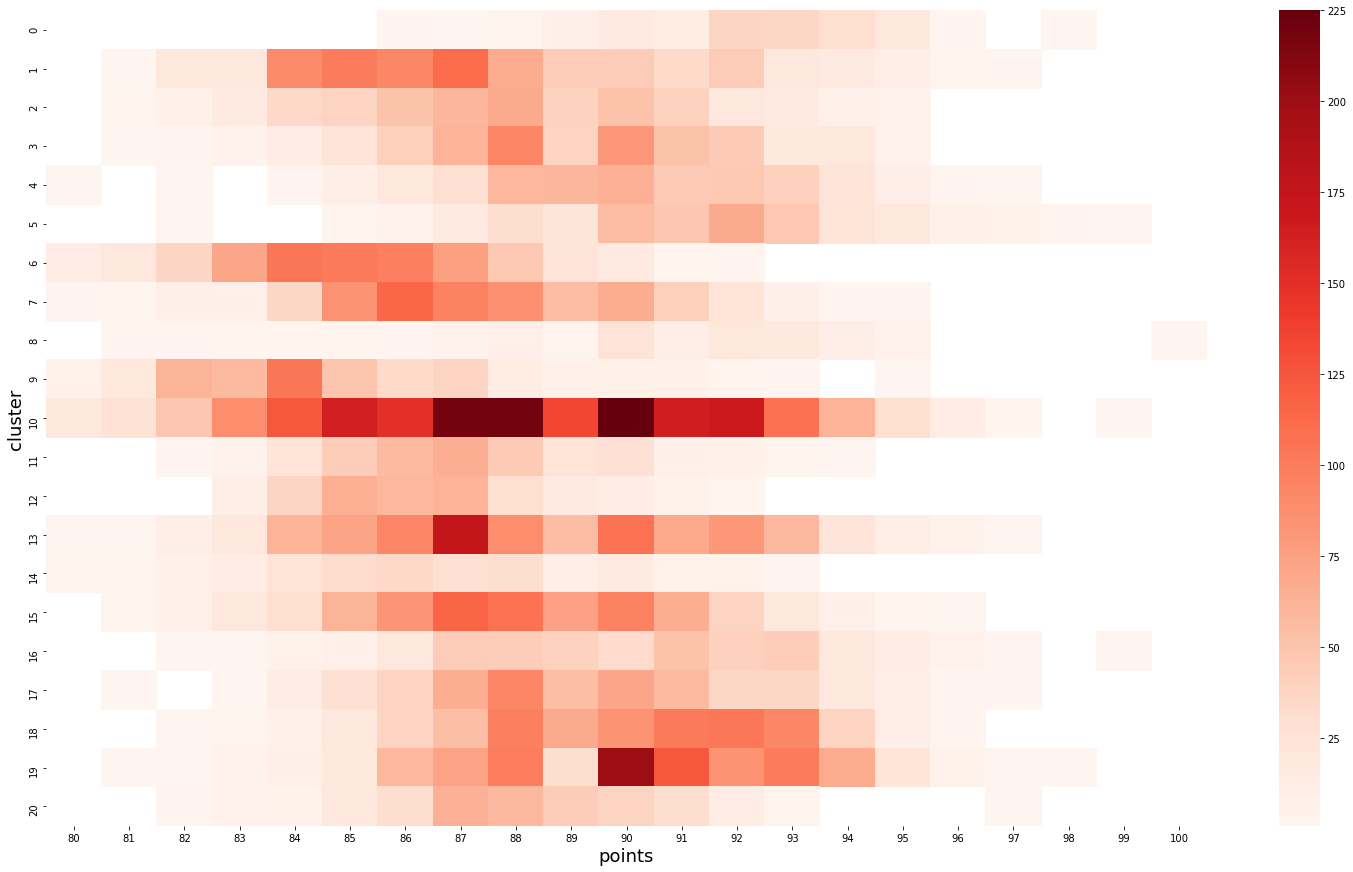

In [85]:
#add the cluster label to the data frame
df['cluster'] = kmeans.labels_

clusters = df.groupby(['cluster', 'points']).size()

fig, ax1 = plt.subplots(figsize = (26, 15))
sns.heatmap(clusters.unstack(level = 'points'), ax = ax1, cmap = 'Reds')

ax1.set_xlabel('points').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

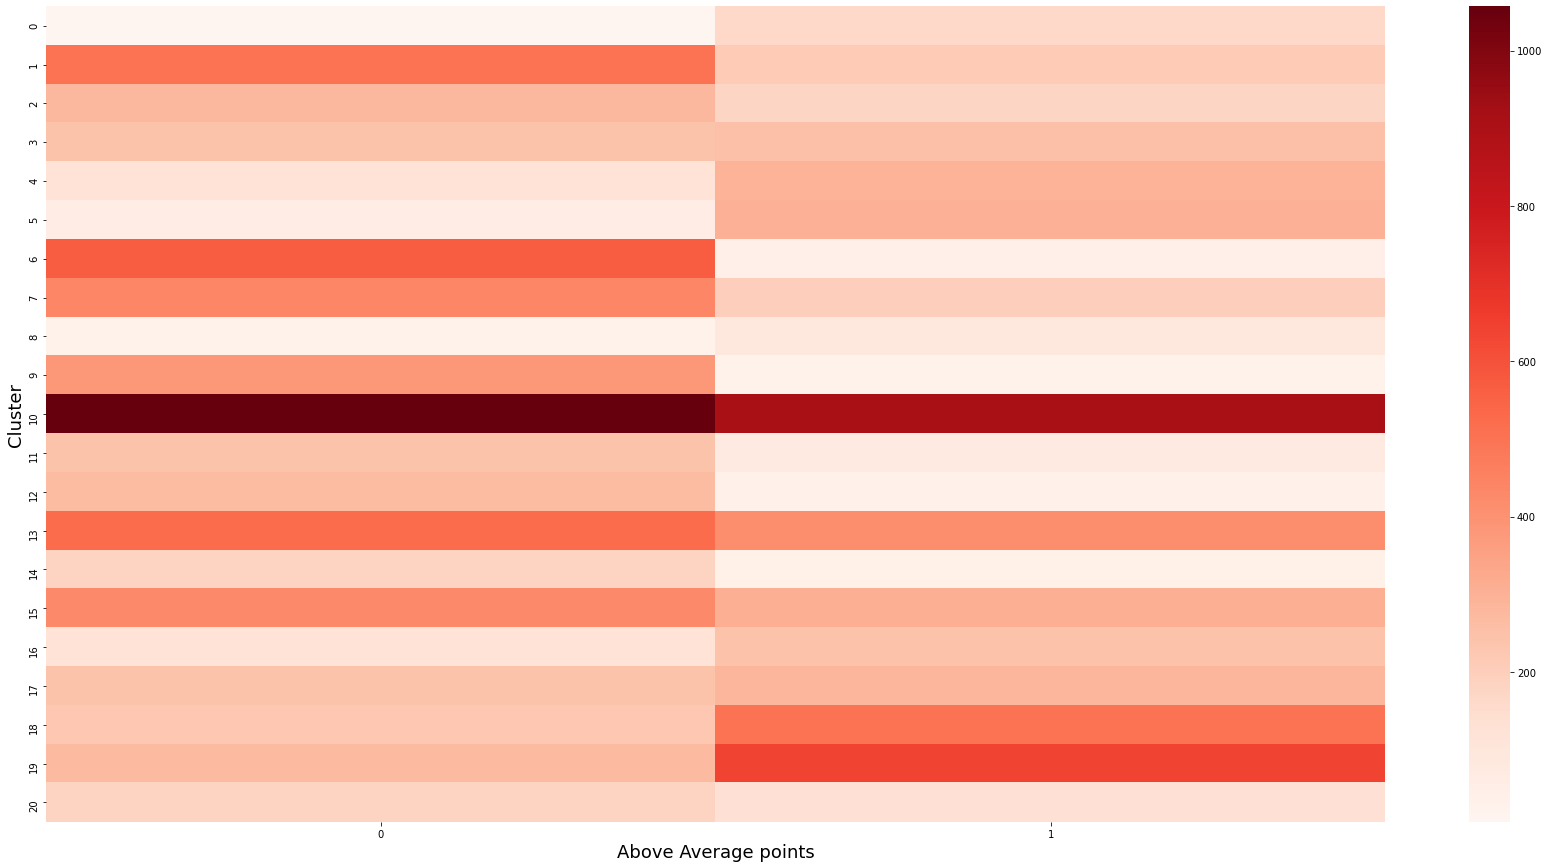

In [87]:
clusters = df.groupby(['cluster', 'above_avg']).size()

fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'above_avg'), ax = ax2, cmap="Reds")

ax2.set_xlabel('Above Average points').set_size(18)
ax2.set_ylabel('Cluster').set_size(18)

In [90]:
#create dataframe of reviews not above average
not_above = df.loc[df['above_avg'] == 0]
not_above.describe()

#create data frame of reviews above average
above_avg = df.loc[df['above_avg'] == 1]
above_avg.describe()

,index,points,price,word_count,cluster,above_avg
count,5377.000000,5377.000000,5022.000000,5377.000000,5377.000000,5377.0
mean,65844.851218,91.265762,49.592792,43.834108,11.220197,1.0
std,37260.545808,1.754948,57.901654,10.069624,6.151263,0.0
min,121.000000,89.000000,8.000000,14.000000,0.000000,1.0
25%,34588.000000,90.000000,28.000000,37.000000,5.000000,1.0
50%,65633.000000,91.000000,39.000000,43.000000,10.000000,1.0
75%,97732.000000,92.000000,54.750000,50.000000,17.000000,1.0
max,129955.000000,100.000000,2013.000000,104.000000,20.000000,1.0


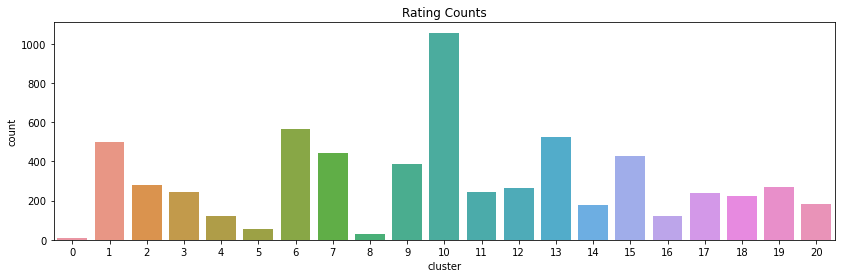

In [91]:
#plot the counts
plt.figure(figsize=(14,4))
sns.countplot(x='cluster', data=not_above).set_title("Rating Counts")
plt.show()

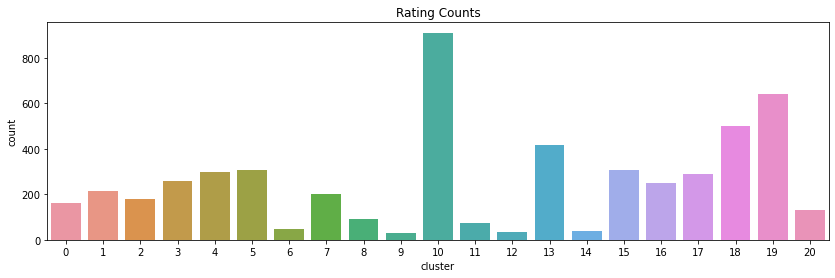

In [89]:
plt.figure(figsize=(14,4))
sns.countplot(x='cluster', data=above_avg).set_title("Rating Counts")
plt.show()